<a href="https://colab.research.google.com/github/Vonewman/Deep_Learning_models_with_pytorch/blob/master/Train_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [63]:
cd ..

/


In [64]:
ls

bin/      dev/   lib32/  opt/   sbin/   tensorflow-1.15.2/  var/
boot/     etc/   lib64/  proc/  srv/    tmp/
content/  home/  media/  root/  swift/  tools/
datalab/  lib/   mnt/    run/   sys/    usr/


In [65]:
cd content

/content


In [66]:
ls

gdrive/  helper.py  sample_data/


# Training Neural Networks

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="content/gdrive/MyDrive/assets/function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='assets/gradient_descent.png' width=350px>

In [67]:
import warnings
warnings.filterwarnings('ignore')

In [68]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [69]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3013, grad_fn=<NllLossBackward>)


In my experience it's more convenient to build the model with a log-softmax output using `nn.LogSoftmax` or `F.log_softmax` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). Then you can get the actual probabilities by taking the exponential `torch.exp(output)`. With a log-softmax output, you want to use the negative log likelihood loss, `nn.NLLLoss` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)).

>**Exercise:** Build a model that returns the log-softmax as the output and calculate the loss using the negative log likelihood loss. Note that for `nn.LogSoftmax` and `F.log_softmax` you'll need to set the `dim` keyword argument appropriately. `dim=0` calculates softmax across the rows, so each column sums to 1, while `dim=1` calculates across the columns so each row sums to 1. Think about what you want the output to be and choose `dim` appropriately.

In [70]:
# TODO: Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.NLLLoss()     # negative log likelihood loss7

images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3155, grad_fn=<NllLossBackward>)


In [71]:
x = torch.randn(2,2, requires_grad=True)
x

tensor([[ 1.1066, -0.8948],
        [ 2.9982, -0.1761]], requires_grad=True)

In [72]:
y = x**2
print(y)

tensor([[1.2246, 0.8006],
        [8.9892, 0.0310]], grad_fn=<PowBackward0>)


In [73]:
print(y.grad_fn)

In [74]:
z = y.mean()
print(z)

tensor(2.7613, grad_fn=<MeanBackward0>)


In [75]:
print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [76]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.5533, -0.4474],
        [ 1.4991, -0.0881]])
tensor([[ 0.5533, -0.4474],
        [ 1.4991, -0.0881]], grad_fn=<DivBackward0>)


## Loss and Autograd together

When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backwards pass.

In [77]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [78]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007],
        [-0.0019, -0.0019, -0.0019,  ..., -0.0019, -0.0019, -0.0019],
        [-0.0042, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042],
        ...,
        [-0.0027, -0.0027, -0.0027,  ..., -0.0027, -0.0027, -0.0027],
        [ 0.0020,  0.0020,  0.0020,  ...,  0.0020,  0.0020,  0.0020],
        [ 0.0023,  0.0023,  0.0023,  ...,  0.0023,  0.0023,  0.0023]])


## Training the network!

There's one last piece we need to start training, an optimizer that we'll use to update the weights with the gradients. We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html). For example we can use stochastic gradient descent with `optim.SGD`. You can see how to define an optimizer below.

In [79]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

Now we know how to use all the individual parts so it's time to see how they work together. Let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network 
* Use the network output to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes. Note that I have a line of code `optimizer.zero_grad()`. When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.

In [80]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[-0.0293,  0.0316,  0.0150,  ...,  0.0321,  0.0144,  0.0342],
        [-0.0334,  0.0126, -0.0103,  ...,  0.0118, -0.0027, -0.0283],
        [-0.0174,  0.0007,  0.0195,  ..., -0.0142,  0.0103, -0.0184],
        ...,
        [ 0.0111,  0.0089, -0.0185,  ...,  0.0109, -0.0303,  0.0209],
        [-0.0143,  0.0346, -0.0313,  ..., -0.0333,  0.0259, -0.0275],
        [-0.0147, -0.0189,  0.0141,  ..., -0.0156, -0.0116, -0.0342]],
       requires_grad=True)
Gradient - tensor([[ 0.0008,  0.0008,  0.0008,  ...,  0.0008,  0.0008,  0.0008],
        [-0.0022, -0.0022, -0.0022,  ..., -0.0022, -0.0022, -0.0022],
        [-0.0034, -0.0034, -0.0034,  ..., -0.0034, -0.0034, -0.0034],
        ...,
        [-0.0036, -0.0036, -0.0036,  ..., -0.0036, -0.0036, -0.0036],
        [ 0.0022,  0.0022,  0.0022,  ...,  0.0022,  0.0022,  0.0022],
        [ 0.0058,  0.0058,  0.0058,  ...,  0.0058,  0.0058,  0.0058]])


In [81]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[-0.0293,  0.0316,  0.0150,  ...,  0.0321,  0.0144,  0.0342],
        [-0.0334,  0.0127, -0.0103,  ...,  0.0118, -0.0027, -0.0282],
        [-0.0174,  0.0007,  0.0195,  ..., -0.0142,  0.0104, -0.0183],
        ...,
        [ 0.0112,  0.0089, -0.0184,  ...,  0.0110, -0.0303,  0.0210],
        [-0.0143,  0.0345, -0.0314,  ..., -0.0333,  0.0259, -0.0275],
        [-0.0147, -0.0190,  0.0140,  ..., -0.0156, -0.0117, -0.0343]],
       requires_grad=True)


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. Some nomenclature, one pass through the entire dataset is called an *epoch*. So here we're going to loop through `trainloader` to get our training batches. For each batch, we'll doing a training pass where we calculate the loss, do a backwards pass, and update the weights.

>**Exercise:** Implement the training pass for our network. If you implemented it correctly, you should see the training loss drop with each epoch.

In [82]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.9338160257603823
Training loss: 0.8824296720754872
Training loss: 0.5251048972357565
Training loss: 0.423405447081208
Training loss: 0.37860798649887034
Training loss: 0.35238287616957986
Training loss: 0.33397044498783185
Training loss: 0.31993829227809206
Training loss: 0.3082949417724665
Training loss: 0.2979883148487824


With the network trained, we can check out it's predictions.

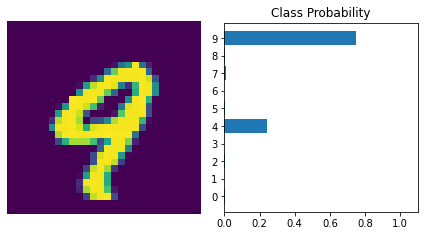

In [86]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()


images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
view_classify(img.view(1, 28, 28), ps)